In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cpu"
model = resnet50_quan(weights=resnet.ResNet50_Weights.IMAGENET1K_V2)
model.to(device)
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)


for name, module in model.named_modules():
    # print(name)
    if hasattr(module, "qconfig"):
        if module.qconfig is not None:
            print(f"{name} | {module.qconfig}")
    if len(name) > 2 and name[-7:] == "act_obs":

        module.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.RecordingObserver.with_args(
                dtype=torch.quint8
            ),
            weight=None,
        )
        print(f"{name} | {module.qconfig}")

layer1.0.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer1.1.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer1.2.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer2.0.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer2.1.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer2.2.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)
layer2.3.act_obs | QConfig(activation=functools.partial(<class 'torch.ao.quantization.ob

In [3]:
prepare(model, inplace=True)

ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (conv2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (bn2): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): Identity()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Identity()
      )
      (relu1): Identity()
      (relu2): Identity()
      (relu3): ReLU()
      (add1): FloatFunctional(
        (ac

In [4]:
# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
batch_size = 32
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=batch_size,
    num_workers=8,
)

# nvidia paper == 1024 images
print(SingleEpochEval(model, train_loader, criterion, device, limit=32))

  0%|          | 32/40037 [00:38<13:16:43,  1.19s/it]

(1.009614497423172, 90.625)


layer1.0.act_obs [32, 32, 256, 56, 56]


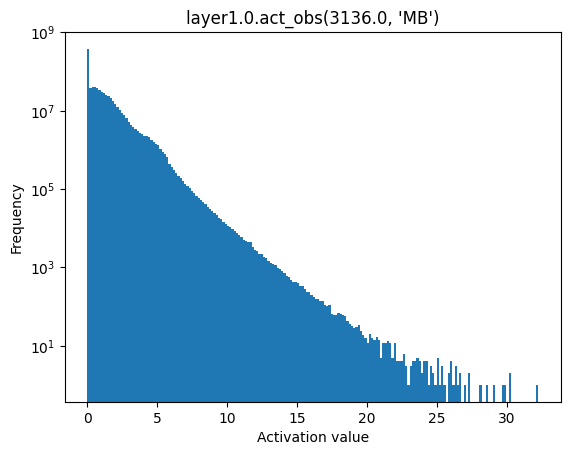

layer1.1.act_obs [32, 32, 256, 56, 56]


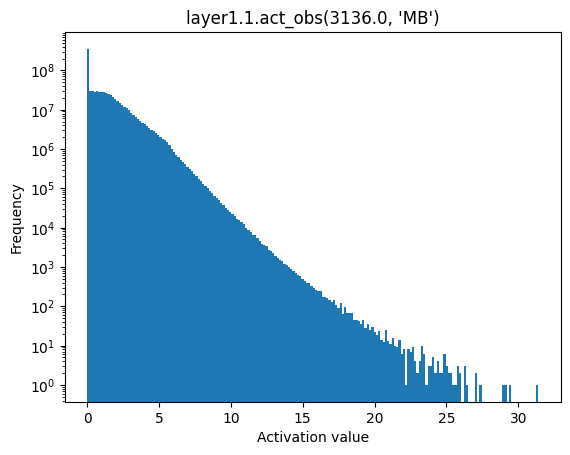

layer1.2.act_obs [32, 32, 256, 56, 56]


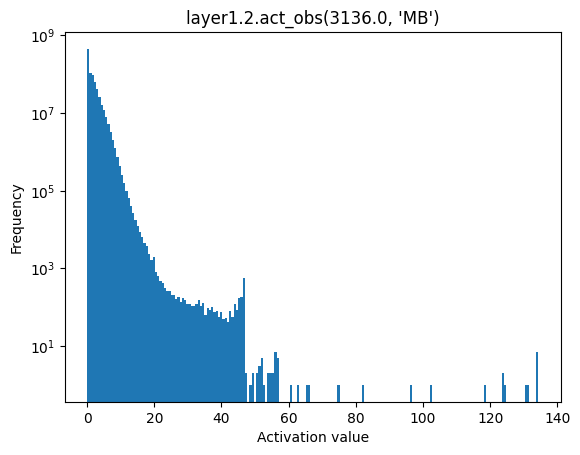

layer2.0.act_obs [32, 32, 512, 28, 28]


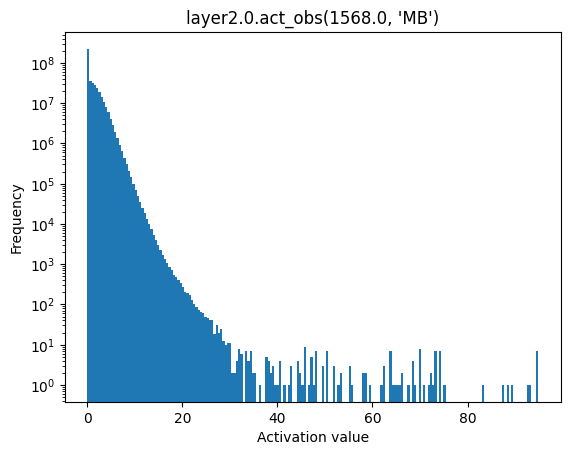

layer2.1.act_obs [32, 32, 512, 28, 28]


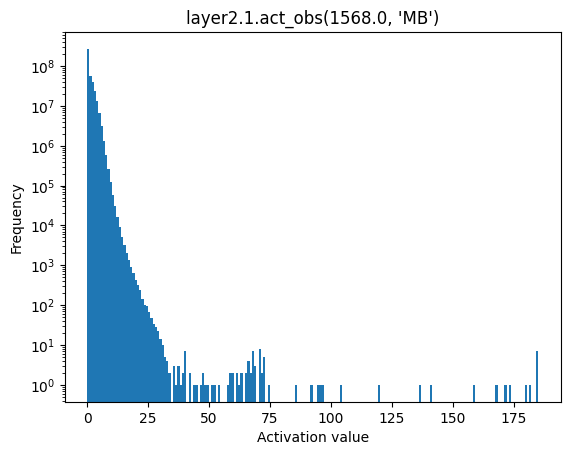

layer2.2.act_obs [32, 32, 512, 28, 28]


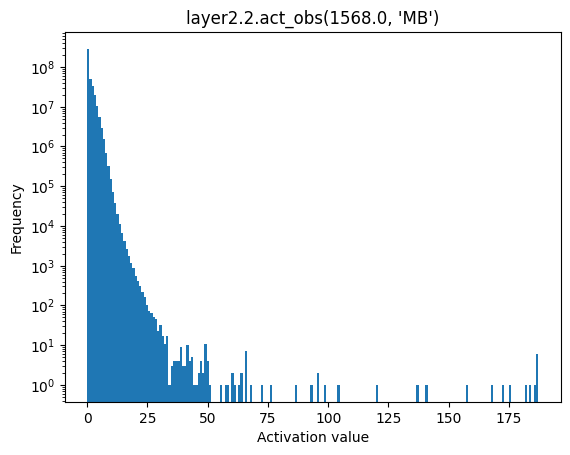

layer2.3.act_obs [32, 32, 512, 28, 28]


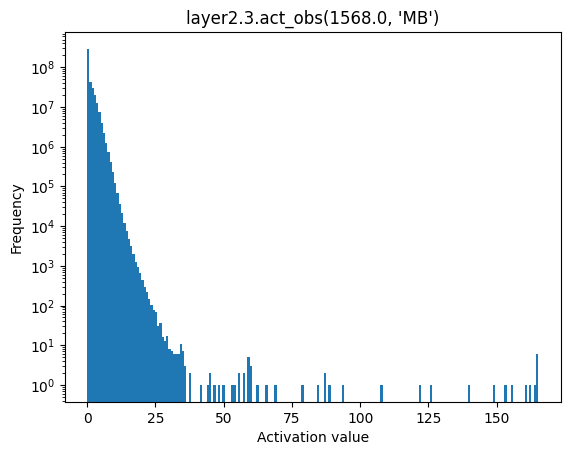

layer3.0.act_obs [32, 32, 1024, 14, 14]


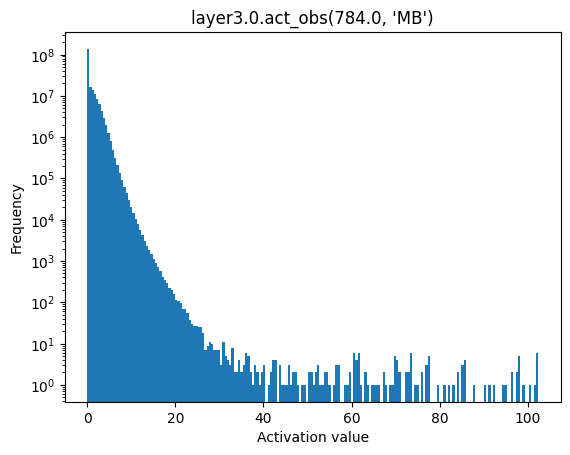

layer3.1.act_obs [32, 32, 1024, 14, 14]


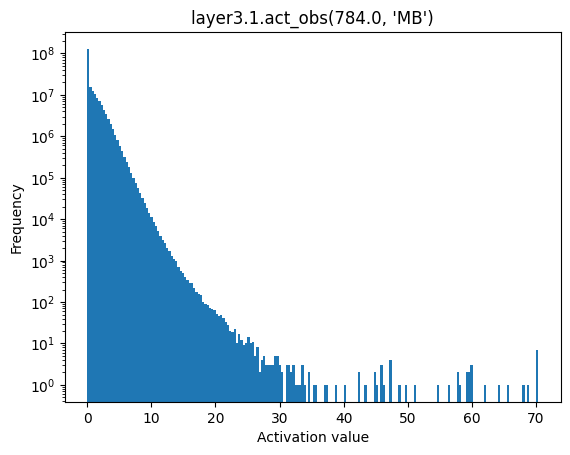

layer3.2.act_obs [32, 32, 1024, 14, 14]


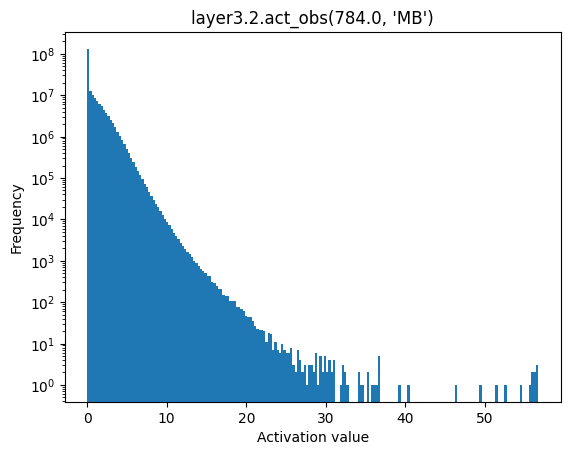

layer3.3.act_obs [32, 32, 1024, 14, 14]


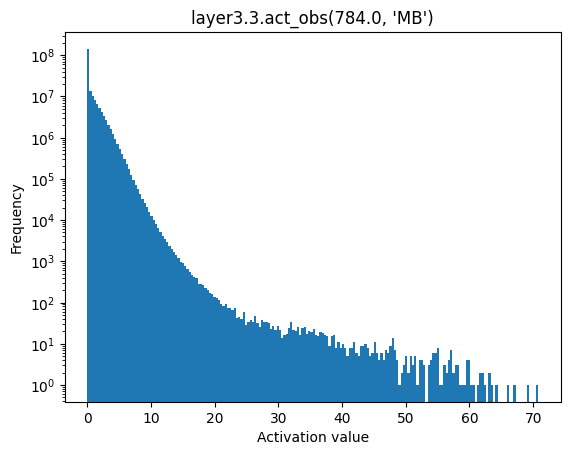

layer3.4.act_obs [32, 32, 1024, 14, 14]


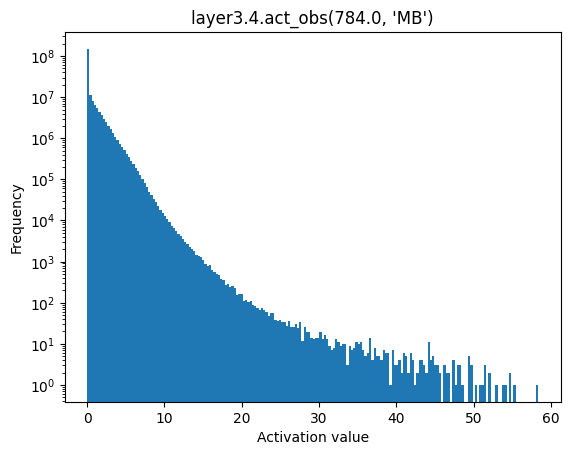

layer3.5.act_obs [32, 32, 1024, 14, 14]


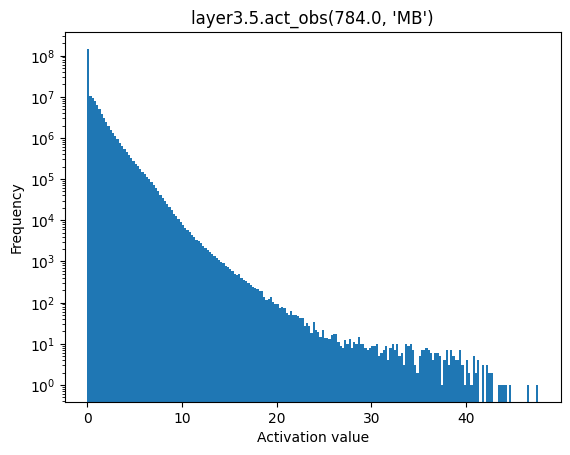

layer4.0.act_obs [32, 32, 2048, 7, 7]


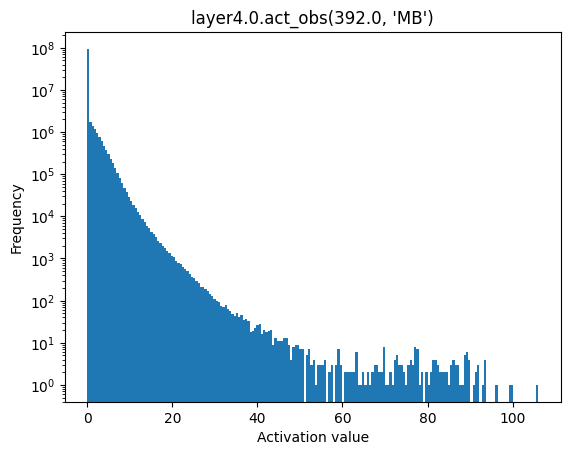

layer4.1.act_obs [32, 32, 2048, 7, 7]


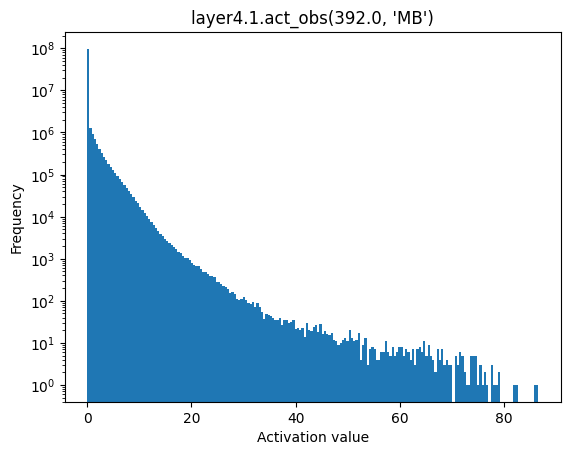

layer4.2.act_obs [32, 32, 2048, 7, 7]


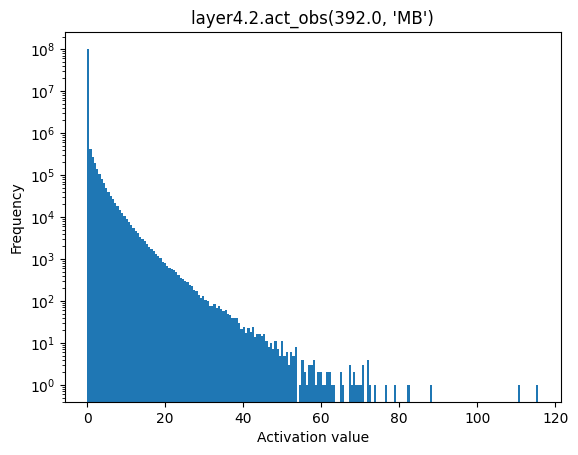

act_obs [32, 32, 64, 56, 56]


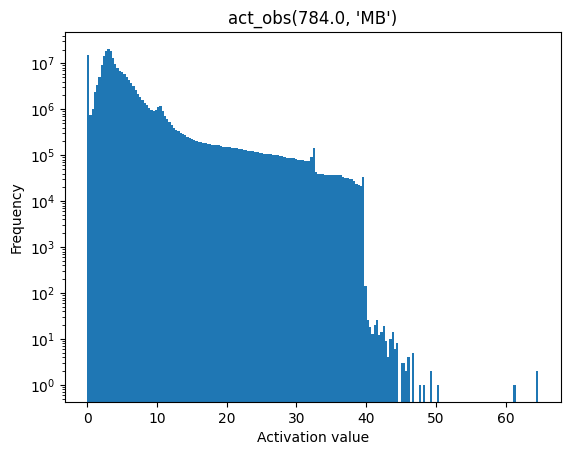

In [7]:
for name, module in model.named_modules():
    if (
        len(name) > 2
        and name[-7:] == "act_obs"
        and hasattr(module, "activation_post_process")
    ):
        # if name == "act_obs":
        print(f"{name}", end=" ")
        wns = module.activation_post_process.get_tensor_value()
        wns = np.array(wns)
        print(list(wns.shape))
        cnt = 1
        for i in list(wns.shape):
            cnt *= i
        wns = wns.flatten()
        plt.hist(wns, bins=200)
        tmp = cnt * 4 / 1024 / 1024, "MB"
        plt.title(name + str(tmp))
        plt.yscale("log")
        plt.xlabel("Activation value")
        plt.ylabel("Frequency")
        plt.show()